In [1]:
import os
import tarfile
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from urllib.request import urlretrieve
from tqdm import tqdm

In [2]:
%matplotlib inline

#### Dataset info

CIFAR-10 is a dataset of 60 000 32x32 colour images, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. There are 10 different classes with 6000 images per class:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

Dataset is divided into 5 batches with the following naming convention 'data_batch_1', 'data_batch_2' and so on...

In [3]:
#: https://www.cs.toronto.edu/~kriz/cifar.html
DATA_URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
TARG_TZ_FILEPATH = "./cifar-10-python.tar.gz"
CIFAR10_FILES_FOLDER = './cifar-10-batches-py/'

TRAIN_BATCH_FILES = [
    "data_batch_1",
    "data_batch_2",
    "data_batch_3",
    "data_batch_4",
    "data_batch_5"
]

TEST_BATCH_FILE = "test_batch"

LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = 10

MAX_PIXEL_VALUE = 255
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
CHANNELS = 3

DATA_I = 0
LABELS_I = 1

#### Download dataset

In [4]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile(TARG_TZ_FILEPATH):
    with DLProgress(unit="B", unit_scale=True, miniters=1, desc="CIFAR-10") as pbar:
        urlretrieve(DATA_URL, TARG_TZ_FILEPATH, pbar.hook)

#### Exctracting data

- Unpacking

In [5]:
if not os.path.isdir(CIFAR10_FILES_FOLDER):
    with tarfile.open(TARG_TZ_FILEPATH) as tar:
        tar.extractall()
        tar.close()

- Loading train batches

In [6]:
train_batches = list()

for batch_file in TRAIN_BATCH_FILES: 
    with open(CIFAR10_FILES_FOLDER + batch_file, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
        # array of 10000 * 1 length
        labels = batch['labels']
        
        # all channels in single 10000 * 3072 length array
        batch_data = batch['data']
        
        # reshaping to 10000 * 3 * 32 * 32
        data = batch_data.reshape((len(batch_data), CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # fix indexing
        data = data.transpose(0, 2, 3, 1)
  
        train_batches.append((data, labels))

- Load test batch

In [7]:
test_batch = None

with open(CIFAR10_FILES_FOLDER + TEST_BATCH_FILE, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
        # array of 10000 * 1 length
        labels = batch['labels']
        
         # all channels in single 10000 * 3072 length array
        batch_data = batch['data']
        
        # reshaping to 10000 * 3 * 32 * 32
        data = batch_data.reshape((len(batch_data), CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # fix indexing
        data = data.transpose(0, 2, 3, 1)
        
        test_batch = (data, labels)

#### Present extracted dataset

In [8]:
def present_batch(batch, batch_index):
    features, labels = batch 
    print("Batch no." + str(batch_index))
    print("    - Samples in batch: " + str(len(features)))
    print("    - Labels num: " + str(dict(zip(*np.unique(labels, return_counts=True)))))
    
def present_sample(batch, sample_id):
    features, labels = batch 
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print("Sample no." + str(sample_id))
    print("    - Min Value: {} Max Value: {}".format(sample_image.min(), sample_image.max()))
    print("    - Shape: {}".format(sample_image.shape))
    print("    - Label - Label Id: {} Name: {}".format(sample_label, LABELS[sample_label]))
    
    plt.axis('off')
    plt.imshow(sample_image)

In [9]:
for index, batch in enumerate(train_batches):
    present_batch(batch, index)

Batch no.0
    - Samples in batch: 10000
    - Labels num: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
Batch no.1
    - Samples in batch: 10000
    - Labels num: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
Batch no.2
    - Samples in batch: 10000
    - Labels num: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
Batch no.3
    - Samples in batch: 10000
    - Labels num: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
Batch no.4
    - Samples in batch: 10000
    - Labels num: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}


Sample no.7164
    - Min Value: 26 Max Value: 246
    - Shape: (32, 32, 3)
    - Label - Label Id: 5 Name: dog


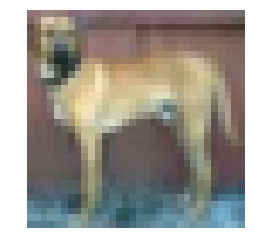

In [10]:
present_sample(train_batches[0], 7164)

#### Split data into train, val , test sets

- data is already shuffled

- concat all batches together

In [11]:
train_data = list()
train_labels = list()
for batch in train_batches:
    for data, label in zip(batch[DATA_I], batch[LABELS_I]):
        train_data.append(data)
        train_labels.append(label)
assert len(train_data) == len(train_labels)
        
test_data = list()
test_labels = list()
for data, label in zip(test_batch[DATA_I], test_batch[LABELS_I]):
    test_data.append(data)
    test_labels.append(label)
assert len(test_data) == len(test_labels)

- split data

In [12]:
split_ratio = 0.2
split_index = int(len(train_data) * split_ratio)

val_data = train_data[:split_index]
val_labels = train_labels[:split_index]

train_data = train_data[split_index:]
train_labels = train_labels[split_index:]

In [13]:
print("Train samples: " + str(len(train_data)))
print("Validation samples: " + str(len(val_data)))
print("Test samples: " + str(len(test_data)))

Train samples: 40000
Validation samples: 10000
Test samples: 10000


#### Preprocess data

In [14]:
def normalize(data):
    return data / MAX_PIXEL_VALUE

def ohe_label(label):
    labels_num = len(LABELS)
  
    encoding_array = np.zeros([labels_num])  
    encoding_array[label] = 1
        
    return encoding_array

In [15]:
train_data_norm = [normalize(data) for data in train_data]
train_labels_ohe = [ohe_label(label) for label in train_labels]

val_data_norm = [normalize(data) for data in val_data]
val_labels_ohe = [ohe_label(label) for label in val_labels]

test_data_norm = [normalize(data) for data in test_data]
test_labels_ohe = [ohe_label(label) for label in test_labels]

In [16]:
sample_to_inspect = 7124
sample = train_data_norm[sample_to_inspect]
label = train_labels_ohe[sample_to_inspect]
print("Sample no." + str(sample_to_inspect))
print("    - Min Value: {} Max Value: {}".format(sample.min(), sample.max()))
print("    - Label: " + str(label))

Sample no.7124
    - Min Value: 0.00784313725490196 Max Value: 0.9137254901960784
    - Label: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


#### Building ConvNet - parts

In [17]:
def conv_net_image_input(image_width, image_height, channels):
    return tf.placeholder(tf.float32, shape=[None, image_width, image_height, channels], name='inputs')

In [18]:
def conv_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=[None, n_classes], name='labels')

In [19]:
def conv_net_keep_prob_input():
    return tf.placeholder(tf.float32, name="keep_prob")

In [20]:
def conv_net_is_training_placeholder():
    return tf.placeholder(tf.bool)

In [21]:
def flatten(tensor):
    conv_output_shape = tensor.get_shape().as_list()
    return tf.reshape(tensor, [-1, conv_output_shape[1] * conv_output_shape[2] * conv_output_shape[3]])

In [22]:
def conv_net(inputs, keep_prob, is_training):  
 
    # Conv Layer - 1, Input 32x32x3, MaxPool 2, Dropout, Output 16x16x32
    conv1_layer = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=[3, 3],
                                   strides=1, padding="SAME", activation=tf.nn.elu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    
    conv1_layer_mpool = tf.layers.max_pooling2d(conv1_layer, pool_size=[2, 2], strides=2)
    conv1_layer_dropout = tf.nn.dropout(conv1_layer_mpool, keep_prob)
    
    # Conv Layer - 2, Input 16x16x32, MaxPool 2, Dropout, Output 8x8x32
    conv2_layer = tf.layers.conv2d(inputs=conv1_layer_dropout, filters=32, kernel_size=[3, 3], 
                                   strides=1, padding="SAME", activation=tf.nn.elu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    
    conv2_layer_mpool = tf.layers.max_pooling2d(conv2_layer, pool_size=[2, 2], strides=2)
    conv2_layer_dropout = tf.nn.dropout(conv2_layer_mpool, keep_prob)
    
    # Conv Layer - 3, Input 8x8x32, MaxPool 2, Dropout, Output 4x4x64
    conv3_layer = tf.layers.conv2d(inputs=conv2_layer_dropout, filters=64, kernel_size=[3, 3], 
                                   strides=1, padding="SAME", activation=tf.nn.elu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    
    conv3_layer_mpool = tf.layers.max_pooling2d(conv3_layer, pool_size=[2, 2], strides=2)
    conv3_layer_dropout = tf.nn.dropout(conv3_layer_mpool, keep_prob)
    
    # Conv Layer Flattened
    flatten_conv_output = flatten(conv3_layer_dropout)

    # Dense Layer 1 - Size 384
    dense1_layer = tf.layers.dense(inputs=flatten_conv_output, units=384, activation=tf.nn.elu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
    dense1_layer_dropout = tf.nn.dropout(dense1_layer, keep_prob)
    
    # Dense Layer 2 - Size 128
    dense2_layer = tf.layers.dense(inputs=dense1_layer_dropout, units=128, activation=tf.nn.elu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
    dense2_layer_dropout = tf.nn.dropout(dense2_layer, keep_prob)
    
    
    # Output Layer 
    output = tf.layers.dense(inputs=dense2_layer_dropout, units=NUM_CLASSES, activation=None,
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
    return output

#### Building ConvNet - assemble

- Reset Tensorflow graph

In [23]:
tf.reset_default_graph()

- Assemble model

In [24]:
inputs = conv_net_image_input(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
targets = conv_net_label_input(NUM_CLASSES)
keep_prob = conv_net_keep_prob_input()
is_training = conv_net_is_training_placeholder()

model = conv_net(inputs, keep_prob, is_training)

- Cost function, training optimizer, correct predictions, accuracy

In [25]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=targets))
optimizer = tf.train.AdamOptimizer().minimize(cost)
correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(targets, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#### Batch preparation

In [26]:
def prepare_mini_batches(data, labels, batch_size):
    assert len(data) == len(labels)
    
    all_batches = list()
    for i in range(0, len(data)):
        all_batches.append((data[i], labels[i]))
    random.shuffle(all_batches)
        
    mini_batches = list()
    while len(all_batches) >= batch_size:
        
        data_batch = list()
        labels_batch = list()
        for j in range(0, batch_size):
            data, labels = all_batches.pop()
            data_batch.append(data)
            labels_batch.append(labels)
            
        mini_batches.append((np.array(data_batch), np.array(labels_batch)))
    
    return mini_batches

#### Hyperparameters

In [27]:
epochs = 110
batch_size = 256
keep_probability = 0.65

#### Training cycle

In [28]:
session = tf.Session()

In [29]:
session.run(tf.global_variables_initializer())

batch_count = 0
info = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[]}
for epoch in range(epochs):
    mini_batches = prepare_mini_batches(train_data_norm, train_labels_ohe, batch_size)

    while mini_batches:
        data_batch, label_batch = mini_batches.pop()
        batch_count += 1

        session.run(optimizer, feed_dict={inputs: data_batch, 
                                          targets: label_batch, 
                                          keep_prob: keep_probability})
        if (batch_count % 50) == 0:
            train_cost = session.run(cost, feed_dict={
                    inputs: data_batch, targets: label_batch, keep_prob: 1.})

            train_acc = session.run(accuracy, feed_dict={
                inputs: data_batch, targets: label_batch, keep_prob: 1.})

            info["train_cost"].append(train_cost)
            info["train_acc"].append(train_acc)

            valid_cost = session.run(cost, feed_dict={
                inputs: val_data_norm, targets: val_labels_ohe, keep_prob: 1.})

            valid_acc = session.run(accuracy, feed_dict={
                inputs: val_data_norm, targets: val_labels_ohe, keep_prob: 1.})

            info["valid_cost"].append(valid_cost)
            info["valid_acc"].append(valid_acc)

            print('Epoch {}, Batch {}:  '.format(epoch + 1, batch_count), end='')
            print("Train cost = ", "{:.4f},".format(train_cost), 
                  "Train acc = ", "{:.4f}".format(train_acc),
                  "Val cost = ", "{:.4f},".format(valid_cost), 
                  "Val acc = ", "{:.4f}".format(valid_acc)) 

Epoch 1, Batch 50:  Train cost =  1.8113, Train acc =  0.3320 Val cost =  1.7994, Val acc =  0.3516
Epoch 1, Batch 100:  Train cost =  1.7784, Train acc =  0.3438 Val cost =  1.7257, Val acc =  0.3723
Epoch 1, Batch 150:  Train cost =  1.5978, Train acc =  0.4219 Val cost =  1.5196, Val acc =  0.4459
Epoch 2, Batch 200:  Train cost =  1.6840, Train acc =  0.4297 Val cost =  1.6781, Val acc =  0.3867
Epoch 2, Batch 250:  Train cost =  1.6060, Train acc =  0.4297 Val cost =  1.5515, Val acc =  0.4402
Epoch 2, Batch 300:  Train cost =  1.4063, Train acc =  0.5039 Val cost =  1.3610, Val acc =  0.5038
Epoch 3, Batch 350:  Train cost =  1.3835, Train acc =  0.5430 Val cost =  1.3786, Val acc =  0.5055
Epoch 3, Batch 400:  Train cost =  1.3863, Train acc =  0.5234 Val cost =  1.4661, Val acc =  0.4769
Epoch 3, Batch 450:  Train cost =  1.4562, Train acc =  0.4805 Val cost =  1.4075, Val acc =  0.4960
Epoch 4, Batch 500:  Train cost =  1.3921, Train acc =  0.5117 Val cost =  1.3343, Val acc =

Epoch 27, Batch 4100:  Train cost =  0.6020, Train acc =  0.8008 Val cost =  0.7230, Val acc =  0.7465
Epoch 27, Batch 4150:  Train cost =  0.7473, Train acc =  0.7070 Val cost =  0.8164, Val acc =  0.7154
Epoch 27, Batch 4200:  Train cost =  0.7185, Train acc =  0.7344 Val cost =  0.7831, Val acc =  0.7281
Epoch 28, Batch 4250:  Train cost =  0.5925, Train acc =  0.8125 Val cost =  0.7154, Val acc =  0.7466
Epoch 28, Batch 4300:  Train cost =  0.5396, Train acc =  0.7891 Val cost =  0.7358, Val acc =  0.7469
Epoch 28, Batch 4350:  Train cost =  0.7007, Train acc =  0.7500 Val cost =  0.7342, Val acc =  0.7464
Epoch 29, Batch 4400:  Train cost =  0.7588, Train acc =  0.7344 Val cost =  0.7368, Val acc =  0.7435
Epoch 29, Batch 4450:  Train cost =  0.5495, Train acc =  0.7969 Val cost =  0.7502, Val acc =  0.7329
Epoch 29, Batch 4500:  Train cost =  0.6405, Train acc =  0.7500 Val cost =  0.7204, Val acc =  0.7495
Epoch 30, Batch 4550:  Train cost =  0.6949, Train acc =  0.7500 Val cost

Epoch 52, Batch 8100:  Train cost =  0.4774, Train acc =  0.8281 Val cost =  0.6925, Val acc =  0.7595
Epoch 53, Batch 8150:  Train cost =  0.4846, Train acc =  0.8438 Val cost =  0.6953, Val acc =  0.7643
Epoch 53, Batch 8200:  Train cost =  0.3656, Train acc =  0.8594 Val cost =  0.6317, Val acc =  0.7803
Epoch 53, Batch 8250:  Train cost =  0.4103, Train acc =  0.8867 Val cost =  0.6222, Val acc =  0.7785
Epoch 54, Batch 8300:  Train cost =  0.4269, Train acc =  0.8594 Val cost =  0.6389, Val acc =  0.7770
Epoch 54, Batch 8350:  Train cost =  0.4051, Train acc =  0.8633 Val cost =  0.6581, Val acc =  0.7707
Epoch 54, Batch 8400:  Train cost =  0.3570, Train acc =  0.8711 Val cost =  0.6214, Val acc =  0.7845
Epoch 55, Batch 8450:  Train cost =  0.3522, Train acc =  0.8672 Val cost =  0.6497, Val acc =  0.7748
Epoch 55, Batch 8500:  Train cost =  0.4314, Train acc =  0.8516 Val cost =  0.6212, Val acc =  0.7814
Epoch 55, Batch 8550:  Train cost =  0.3980, Train acc =  0.8672 Val cost

Epoch 78, Batch 12100:  Train cost =  0.3394, Train acc =  0.8516 Val cost =  0.5965, Val acc =  0.7918
Epoch 78, Batch 12150:  Train cost =  0.3047, Train acc =  0.9023 Val cost =  0.5938, Val acc =  0.7957
Epoch 79, Batch 12200:  Train cost =  0.1972, Train acc =  0.9375 Val cost =  0.5940, Val acc =  0.7954
Epoch 79, Batch 12250:  Train cost =  0.3119, Train acc =  0.9062 Val cost =  0.5926, Val acc =  0.7929
Epoch 79, Batch 12300:  Train cost =  0.3796, Train acc =  0.8711 Val cost =  0.6126, Val acc =  0.7877
Epoch 80, Batch 12350:  Train cost =  0.3040, Train acc =  0.8906 Val cost =  0.5966, Val acc =  0.7936
Epoch 80, Batch 12400:  Train cost =  0.3512, Train acc =  0.8906 Val cost =  0.6290, Val acc =  0.7870
Epoch 80, Batch 12450:  Train cost =  0.2660, Train acc =  0.9141 Val cost =  0.5875, Val acc =  0.7928
Epoch 81, Batch 12500:  Train cost =  0.2215, Train acc =  0.9453 Val cost =  0.5896, Val acc =  0.7918
Epoch 81, Batch 12550:  Train cost =  0.2025, Train acc =  0.941

Epoch 103, Batch 16050:  Train cost =  0.2496, Train acc =  0.9336 Val cost =  0.5722, Val acc =  0.8065
Epoch 104, Batch 16100:  Train cost =  0.2331, Train acc =  0.9180 Val cost =  0.5865, Val acc =  0.7998
Epoch 104, Batch 16150:  Train cost =  0.1521, Train acc =  0.9648 Val cost =  0.5642, Val acc =  0.8071
Epoch 104, Batch 16200:  Train cost =  0.2318, Train acc =  0.9219 Val cost =  0.5944, Val acc =  0.7970
Epoch 105, Batch 16250:  Train cost =  0.1821, Train acc =  0.9688 Val cost =  0.5915, Val acc =  0.7977
Epoch 105, Batch 16300:  Train cost =  0.1594, Train acc =  0.9648 Val cost =  0.5896, Val acc =  0.8023
Epoch 105, Batch 16350:  Train cost =  0.2649, Train acc =  0.9102 Val cost =  0.5728, Val acc =  0.8053
Epoch 106, Batch 16400:  Train cost =  0.2331, Train acc =  0.9102 Val cost =  0.5935, Val acc =  0.7956
Epoch 106, Batch 16450:  Train cost =  0.2065, Train acc =  0.9414 Val cost =  0.5692, Val acc =  0.7997
Epoch 106, Batch 16500:  Train cost =  0.1932, Train ac

#### Results

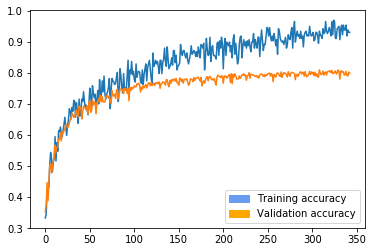

In [30]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(info['train_acc'], label='Training acc')
ax1.plot(info['valid_acc'], label='Validation acc')
blue_patch = mpatches.Patch(color='#699cef', label='Training accuracy')
orange_patch = mpatches.Patch(color='orange', label='Validation accuracy')
ax1.legend(handles=[blue_patch, orange_patch])
plt.show()

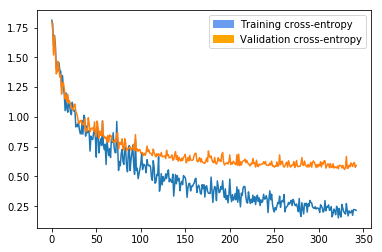

In [31]:
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
ax2.plot(info['train_cost'], label='Training loss')
ax2.plot(info['valid_cost'], label='Validation loss')
blue_patch = mpatches.Patch(color='#699cef', label='Training cross-entropy')
orange_patch = mpatches.Patch(color='orange', label='Validation cross-entropy')
ax2.legend(handles=[blue_patch, orange_patch])
plt.show()

#### Test accuracy

In [32]:
test_acc = session.run(accuracy, feed_dict={
    inputs: test_data_norm, targets: test_labels_ohe, keep_prob: 1.})
print("Test data accuracy: " + str(test_acc))

Test data accuracy: 0.7904


In [33]:
session.close()